In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import joblib

texts = [
    "La historia de un dragón que protege una aldea",
    "Un caballero lucha contra un monstruo en una cueva",
    "Cómo hacer pan casero con pocos ingredientes",
    "Recetas veganas fáciles para el día a día",
    "La vida secreta de los gatos en la ciudad",
    "Por qué los perros son los mejores amigos del hombre"
]
# 1. Generar embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(texts)

# 2. Agrupar los textos en 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(embeddings)

# 3. Mostrar resultados agrupados
for i, text in enumerate(texts):
    print(f"[Cluster {labels[i]}] {text}")

print("Modelo KMeans y datos procesados guardados correctamente.")

[Cluster 2] La historia de un dragón que protege una aldea
[Cluster 2] Un caballero lucha contra un monstruo en una cueva
[Cluster 0] Cómo hacer pan casero con pocos ingredientes
[Cluster 0] Recetas veganas fáciles para el día a día
[Cluster 1] La vida secreta de los gatos en la ciudad
[Cluster 1] Por qué los perros son los mejores amigos del hombre
Modelo KMeans y datos procesados guardados correctamente.


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(



Cluster 0 (L'enfant caché de Medjugorje (EDB)):
                                             book_title  \
1151  Envoy for Christ: 25 Years as a Catholic Apolo...   
49                               The Dogma of Purgatory   
170                             Santa Catalina de Siena   
376           My Russian Way: a spiritual autobiography   
712                     Praying the Rosary Step-by-Step   
192                            El libro de los mártires   
644           On the Third Part of the Secret of Fatima   
675           Mysterium Paschale: The Mystery of Easter   
70    Roses in the Snow: A Tale of Saint Elizabeth o...   
901                         Thoughts of the Curé of Ars   
428          El Hermano de Asis (San Francisco de Asis)   
553   La Messa cattolica: Passi per ripristinare la ...   
1137  Crosses, Sunsets & Sinners: A Brother And Sist...   
526   Total Consecration Through the Mysteries of th...   
570                    Poems Every Catholic Should Know   
101    

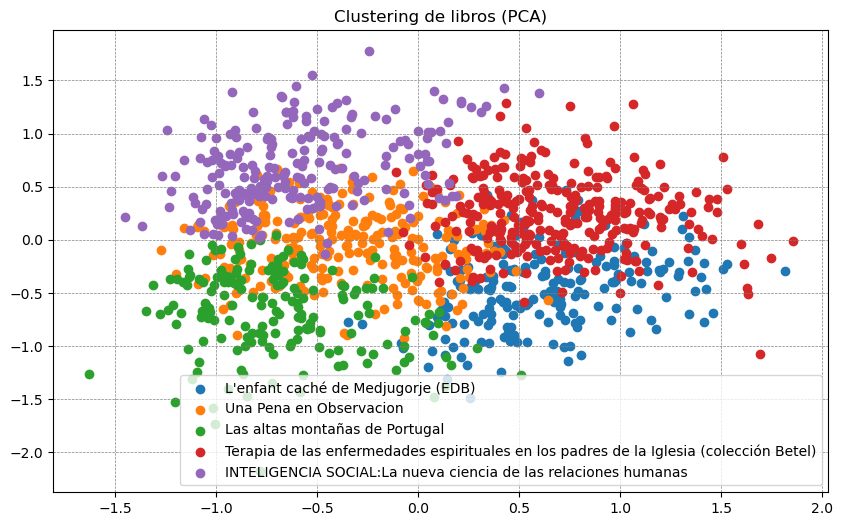

In [8]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
import numpy as np

# Definir stop-words
my_stop_words = {
    'to-read', 'closed', 'abandoned-books', 'rating-top', 'literature', 'not-interested', 'libricos', 'recommended',
    '000-next', '001-ladder-top', '002-ladder-short-term', '003-ladder-medium-term', '004-ladder-long-term',
    '005-ladder-maybe-someday', '_cristina', '_giorgia', '_natalia', '_nieves', '_pilar', '_sindy', '_víctor', 'chełmińska'
}
stop_words = set(my_stop_words)
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(stopwords.words('spanish')))
stop_words = stop_words.union(set(stopwords.words('french')))
stop_words = stop_words.union(set(stopwords.words('italian')))

# Función para filtrar stop-words de los textos
def filter_stopwords(text):
    words = text.split()
    return ' '.join(word for word in words if word.lower() not in stop_words)

# 1. Cargar el dataset
df = pd.read_csv('../data/processed/books.csv')

# 2. Combinar título y blurb como entrada textual y filtrar stop-words
df['text'] = (df['book_title'].fillna('') + '. ' + df['blurb'].fillna('')).apply(filter_stopwords)

# 3. Generar embeddings con SentenceTransformer
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# 4. Dividir el dataset en entrenamiento (80%) y prueba (20%)
X_train, X_test, df_train, df_test = train_test_split(embeddings, df, test_size=0.2, random_state=42)

# 5. Entrenar modelo de clustering (KMeans)
n_clusters = 5  # Número de clusters (puedes ajustarlo según el caso)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train)

# Guardar el modelo KMeans entrenado
joblib.dump(kmeans, "../model/book_clustering_kmeans.joblib")

# Guardar el DataFrame procesado con los textos y clusters
# df.to_csv("../data/processed/books_with_clusters.csv", index=False)

# 6. Predecir clusters para el conjunto de prueba
df_test['cluster'] = kmeans.predict(X_test)

# 7. Asignar nombres significativos a los clusters
cluster_names = []
for cluster in range(n_clusters):
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]
    cluster_center = kmeans.cluster_centers_[cluster]
    closest_index = cluster_indices[np.argmin(np.linalg.norm(X_train[cluster_indices] - cluster_center, axis=1))]
    cluster_names.append(df_train.iloc[closest_index]['book_title'])

# 8. Visualizar resultados agrupados
for cluster in range(n_clusters):
    print(f"\nCluster {cluster} ({cluster_names[cluster]}):")
    print(df_test[df_test['cluster'] == cluster][['book_title', 'tags']])

# 9. Visualización opcional con PCA (reducción a 2D)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
df['cluster'] = kmeans.predict(embeddings)

df.to_csv("../data/processed/clustering_books.csv", index=False)

plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_points = reduced_embeddings[df['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'{cluster_names[cluster]}')

# Añadir grid con líneas discontinuas
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('Clustering de libros (PCA)')
plt.legend()
# Guardar jpg
plt.savefig('../img/clustering_books.jpg', dpi=300, bbox_inches='tight')
plt.show()